## Overall EDA Findings

### Class Balance
There is class imbalance in this dataset ~13% 'bad'/~87% 'good'. While this isn't terrible, class imbalance can still lead to poor predictive accuracy in the infrequent class. For this model/dataset it is something to keep an eye on, especially after data cleaning. We want to make sure that our class imbalance doesn't get worse. 

### N/A Values
Columns in this dataset fall into one of four tiers of N/A counts: None, Rare, Semi-Rare, Numerous.
- Rare (<=35) N/A count rows can be dropped. I've shown below that there is heavy overlap in the rare column N/A values, meaning if one rare column is N/A, the liklihood that another rare column is N/A is _very_ high.
- There is only one semi-rare N/A count column: emp_title.
- There are three numerous tier columns: mths_since_last_record, mths_since_last_delinq, Notes.

### N/A Imputation
There are three obvious candidate columns for N/A imputation: mths_since_last_record, mths_since_last_delinq, emp_title.

**emp_title**

The easiest option here would be to set all N/A values to an empty string, however, this ignores the shape of the data.  The vast majority of rows have "long tail" employers (<=3 data points mapped to that employer), or they are poorly formatted. When building the logistic regression model, creating dummies for long tail employers will lead to over fitting. I'll likely have an "other" category for these employers.

**mths_since_last_record, mths_since_last_delinq**

There are two imputation strategies required, one for each model type (tree or regression based). For tree based models, I can likely choose a very large number or simply -1. The tree should be able to split on this, provided the features are meaningful for the model. For logistic regression, the imputation value is very important because we will be imposing bias on the data, based on what we choose. 

More analysis on this will come later.

### Categorical Data
Several categorical data columns can be simplified or summarized. As an example, one assumption is that "VERIFIED - income" == "VERIFIED - income source", which can be mapped to the same value. Other columns can likely be dropped because they will lead to overfitting (pymnt_plan).

### 'Commentary' Fields
Several fields have commentary (notes, purpose, purpose_cat) which may be able to be boiled down to more informative features.

### Outlier/Nonsensical Data
Several fields have non-sensical or outlier data which can be dropped.

In [1]:
import datetime 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('../data/DR_Demo_Lending_Club.csv')

## Lightweight Preanalysis Cleanup

In [3]:
## Casting earliest_cr_line to a datetime, then calculating days since.
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
current_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
df['days_since_earliest_cr_line'] = (current_date - df['earliest_cr_line']).dt.days

df.loc[df['emp_length'] == 'na', 'emp_length'] = np.nan
df['emp_length'] = df['emp_length'].astype('float64')

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_df = df.select_dtypes(include=numerics).drop(['Id'], axis=1)
non_numerical_df = df.select_dtypes(exclude=numerics)

In [5]:
df.head()

,Id,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,days_since_earliest_cr_line
0,1,0,Time Warner Cable,10.0,MORTGAGE,50000.0,not verified,n,NaN,medical,...,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4,9639.0
1,2,0,Ottawa University,1.0,RENT,39216.0,not verified,n,Borrower added on 04/14/11 > I will be using...,debt consolidation,...,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1,4921.0
2,3,0,Kennedy Wilson,4.0,RENT,65000.0,not verified,n,NaN,credit card,...,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4,17858.0
3,4,0,TOWN OF PLATTEKILL,10.0,MORTGAGE,57500.0,not verified,n,NaN,debt consolidation,...,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2,13383.0
4,5,0,Belmont Correctional,10.0,MORTGAGE,50004.0,VERIFIED - income,n,"I want to consolidate my debt, pay for a vacat...",debt consolidation,...,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3,7144.0


## Data Types

In [6]:
df.dtypes

Id                                      int64
is_bad                                  int64
emp_title                              object
emp_length                            float64
home_ownership                         object
annual_inc                            float64
verification_status                    object
pymnt_plan                             object
Notes                                  object
purpose_cat                            object
purpose                                object
zip_code                               object
addr_state                             object
debt_to_income                        float64
delinq_2yrs                           float64
earliest_cr_line               datetime64[ns]
inq_last_6mths                        float64
mths_since_last_delinq                float64
mths_since_last_record                float64
open_acc                              float64
pub_rec                               float64
revol_bal                         

## Summarize Data

### Numeric Data

In [7]:
## Numeric Data
df.describe()

,Id,is_bad,emp_length,annual_inc,debt_to_income,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,days_since_earliest_cr_line
count,10000.00000,10000.000000,9750.000000,9999.000000,10000.000000,9995.000000,9995.000000,3684.000000,840.000000,9995.000000,9995.000000,1.000000e+04,9974.000000,9995.000000,9968.0,10000.000000,9995.000000
mean,5000.50000,0.129500,4.988615,68203.011539,13.338704,0.148174,1.066933,35.890337,61.652381,9.334567,0.060130,1.427101e+04,48.450771,22.011306,0.0,2.002200,8092.297149
std,2886.89568,0.335769,3.447625,48590.252757,6.754212,0.506270,1.476052,22.361443,46.189619,4.526590,0.251245,2.543791e+04,28.220557,11.709400,0.0,0.810963,2497.137555
min,1.00000,0.000000,1.000000,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.0,1.000000,3825.000000
25%,2500.75000,0.000000,2.000000,40000.000000,8.160000,0.000000,0.000000,18.000000,0.000000,6.000000,0.000000,3.524500e+03,25.000000,13.000000,0.0,1.000000,6413.000000
50%,5000.50000,0.000000,4.000000,58000.000000,13.410000,0.000000,1.000000,34.000000,86.000000,9.000000,0.000000,8.645500e+03,48.700000,20.000000,0.0,2.000000,7631.000000
75%,7500.25000,0.000000,9.000000,82000.000000,18.692500,0.000000,2.000000,53.000000,101.000000,12.000000,0.000000,1.695225e+04,71.800000,29.000000,0.0,3.000000,9243.000000
max,10000.00000,1.000000,33.000000,900000.000000,29.990000,11.000000,25.000000,120.000000,119.000000,39.000000,3.000000,1.207359e+06,100.600000,90.000000,0.0,3.000000,24980.000000


### Categorical Data

In [8]:
def groupby_and_count(df, col):
    return df.groupby(col).count()['Id'].sort_values(ascending=False)

In [9]:
## Employer
employer_dist = groupby_and_count(df, 'emp_title')
employer_dist.head(10)

emp_title
US Army                    36
Bank of America            23
IBM                        22
USAF                       17
United States Air Force    16
US Navy                    15
Wells Fargo                14
Self Employed              14
AT&T                       14
U.S. Army                  14
Name: Id, dtype: int64

In [10]:
## Employer Distribution
sum(employer_dist[employer_dist.values <= 3].values)

8584

In [11]:
for col in non_numerical_df:
    if col not in ['Notes']:
        print(groupby_and_count(df, col).head(10))
        print()

emp_title
US Army                    36
Bank of America            23
IBM                        22
USAF                       17
United States Air Force    16
US Navy                    15
Wells Fargo                14
Self Employed              14
AT&T                       14
U.S. Army                  14
Name: Id, dtype: int64

home_ownership
RENT        4745
MORTGAGE    4445
OWN          775
OTHER         34
NONE           1
Name: Id, dtype: int64

verification_status
not verified                4367
VERIFIED - income           3214
VERIFIED - income source    2419
Name: Id, dtype: int64

pymnt_plan
n    9998
y       2
Name: Id, dtype: int64

purpose_cat
debt consolidation    4454
credit card           1273
other                 1026
home improvement       800
major purchase         546
small business         461
car                    349
wedding                250
medical                183
moving                 159
Name: Id, dtype: int64

purpose
Debt Consolidation           5

## Class Balance

Evidenced below, we have roughly a 10/90 class imbalance. Will likely need to do some sort of re-sampling.

In [32]:
print('Count of "is_bad" data points:         {}'.format(len(df[df['is_bad']==1])))
print('Percent of total "is_bad" data points: {}'.format((len(df[df['is_bad']==1]))/len(df)))

print()
print('Count of "is_ok" data points:         {}'.format(len(df[df['is_bad']==0])))
print('Percent of total "is_ok" data points: {}'.format((len(df[df['is_bad']==0]))/len(df)))


Count of "is_bad" data points:         1295
Percent of total "is_bad" data points: 0.1295

Count of "is_ok" data points:         8705
Percent of total "is_ok" data points: 0.8705


## N/A Value Analysis

In [33]:
na_counts = pd.DataFrame()
for col in df:
    na_counts = na_counts.append(
        pd.DataFrame(
            {
                'column':col,
                'na_count':len(df[df.isna()[col]])
            }, index=[0]
        )
    )
na_counts.reset_index(drop=True).sort_values('na_count', ascending=False)

,column,na_count
18,mths_since_last_record,9160
17,mths_since_last_delinq,6316
8,Notes,3167
2,emp_title,592
3,emp_length,250
25,collections_12_mths_ex_med,32
22,revol_util,26
14,delinq_2yrs,5
15,earliest_cr_line,5
23,total_acc,5


### NA Counts and Imputation Ideas

- **emp_title**
    - NA Count: 592
    - Imputation: Could set to '', however that might be an issue. Maybe we can infer a value? Unlikely. Dropping is risky, as it represents ~5% of our data.
- **annual_inc**
    - NA Count: 1
    - Imputation: I will drop this row.
- **Notes**
    - NA Count: 3167
    - Imputation: Unsure of the importance of this particular feature. Not going to worry about imputation at this point.
- **purpose**
    - NA Count: 4
    - Imputation: Unsure of the importance of this particular feature. Given the number of points, will likely drop.
- **delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, total_acc**
    - NA Count: 5 Total across all of these columns.
    - Imputation: Will drop.
- **mths_since_last_delinq, mths_since_last_record**
    - Count: **A lot.**
    - Imputation: There are three things that come to mind: (1) Set these values equal to a really high value, (2) set them equal to -1, (3) set them equal to number of months since earliest_cr_line.                  
- **revol_util**
    - NA Count: 26
- **collections_12_mths_ex_med**
    - NA Count: 32
    - Imputation: For both this, and the value above, I can likely use some mean, median imputation.

## Plotting Numerical Data

/Users/jakeweholt/.virtualenvs/DR_TH/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jakeweholt/.virtualenvs/DR_TH/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


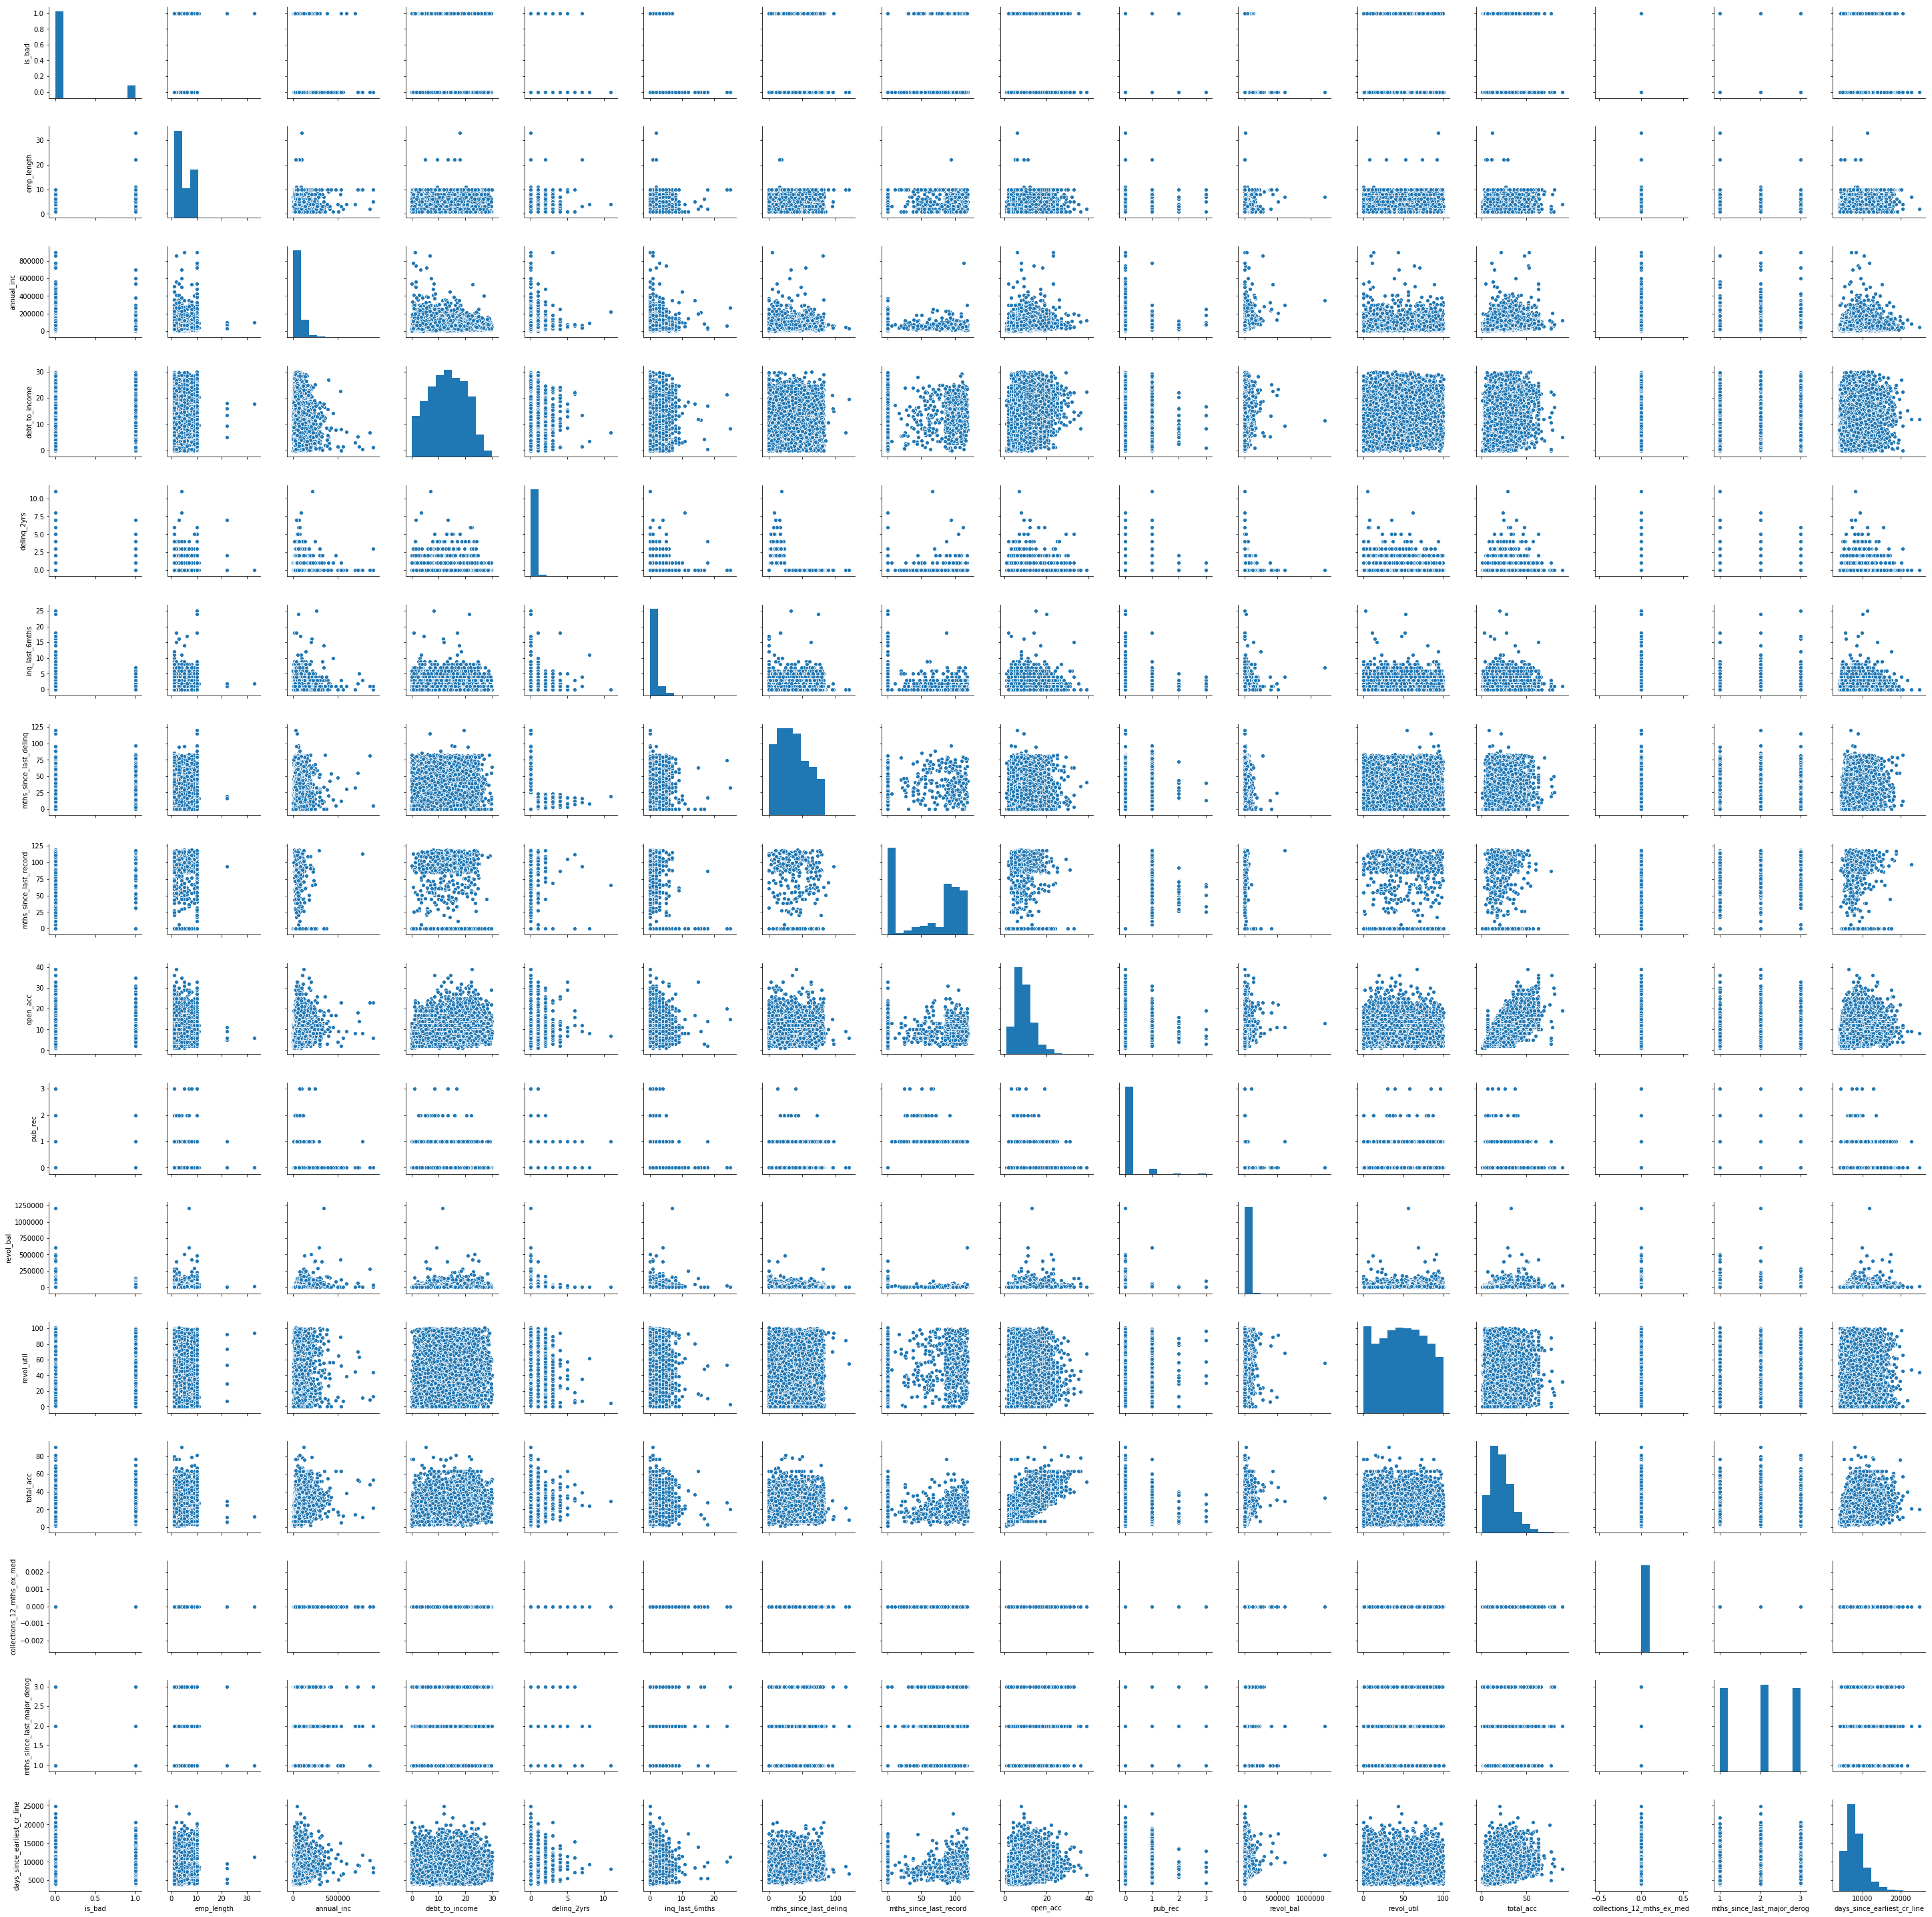

In [34]:
sns.pairplot(numerical_df)

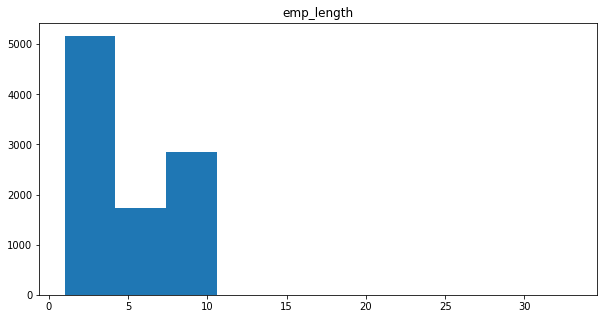

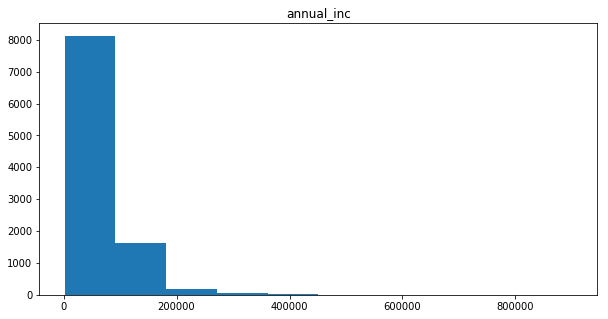

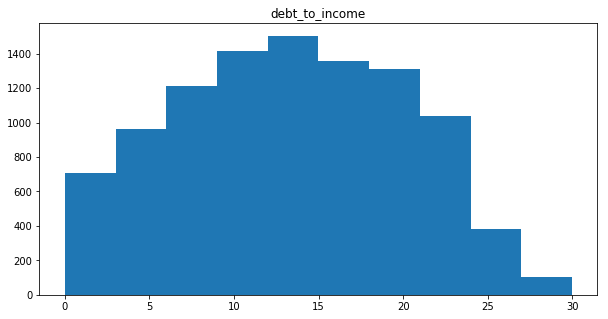

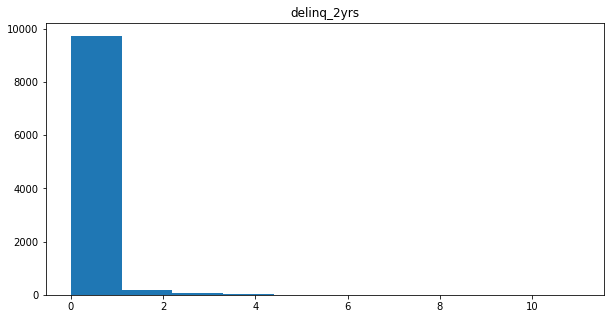

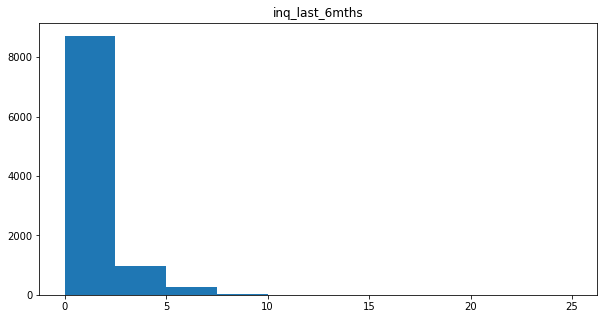

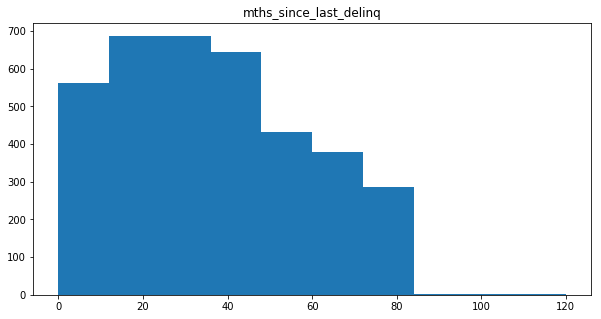

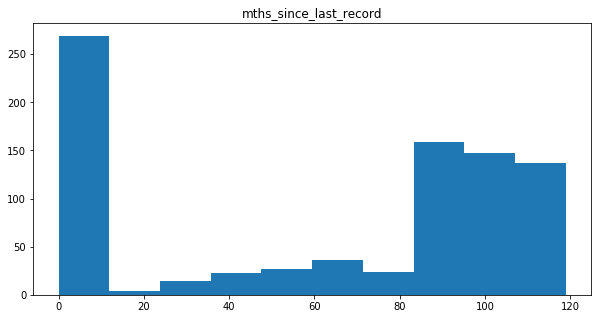

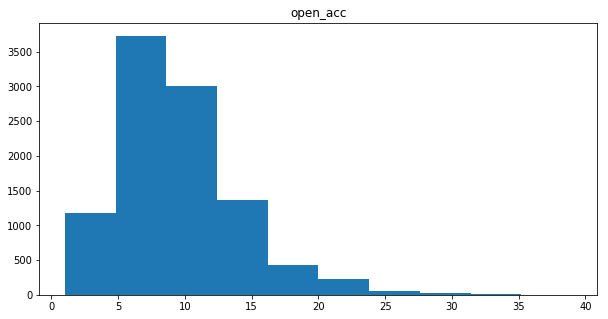

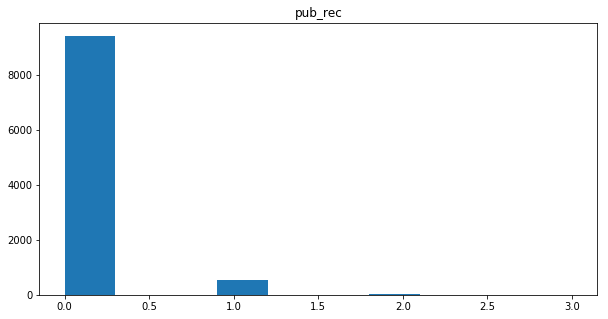

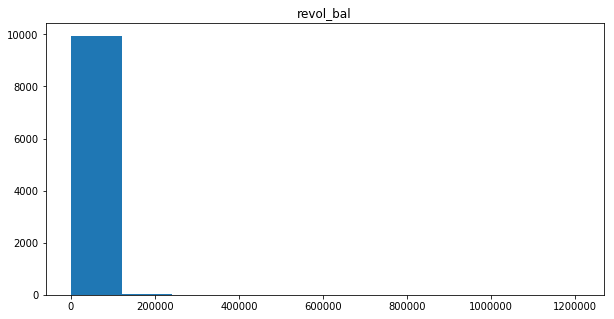

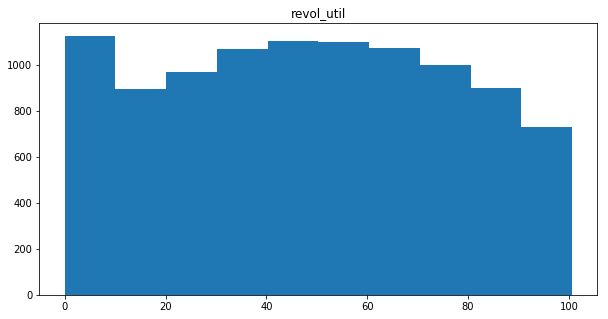

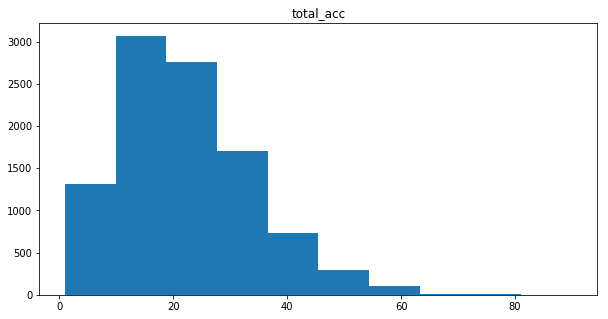

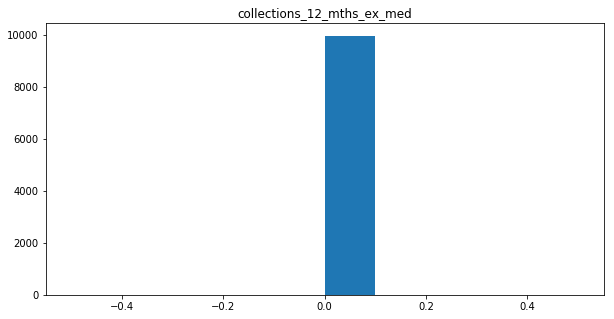

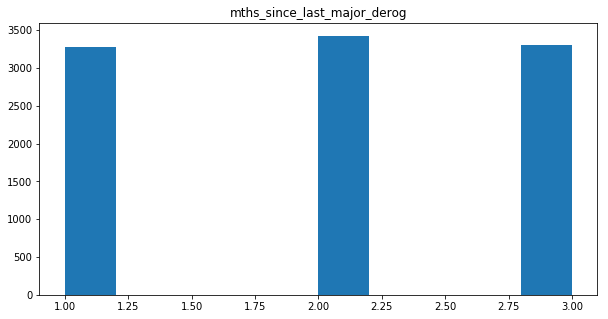

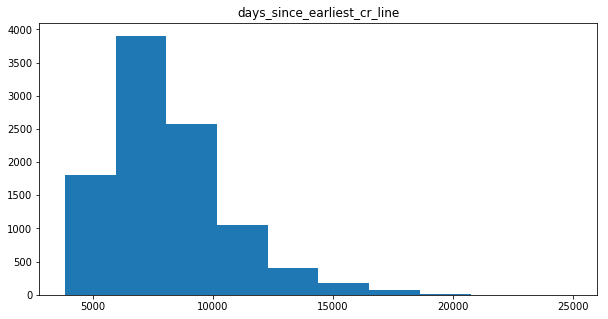

In [35]:
numerical_df = numerical_df.drop(['is_bad'], axis=1)
for col in numerical_df:
    plt.figure(figsize=[10,5])
    plt.hist(numerical_df[col])
    plt.title(col)

## Extreme Values

### Outliers

In [36]:
## These are good.
df.sort_values('annual_inc', ascending=False)['annual_inc'].head()

240     900000.0
7973    900000.0
8933    860000.0
7425    780000.0
1296    744000.0
Name: annual_inc, dtype: float64

In [37]:
## The Max revolving balance is over double the next closest value, it can likely be dropped because it's an outlier.
df.sort_values('revol_bal', ascending=False)['revol_bal'].head()

159     1207359
4695     602519
2835     508961
5480     487589
7453     423189
Name: revol_bal, dtype: int64

In [38]:
## 11 might be an outlier, given the distribution of the delinq_2yrs column. Undetermined at this point.
df.sort_values('delinq_2yrs', ascending=False)['delinq_2yrs'].head()

4014    11.0
6624     8.0
8443     7.0
699      7.0
2432     6.0
Name: delinq_2yrs, dtype: float64

In [39]:
## This seems pretty reasonable.
df.sort_values('earliest_cr_line', ascending=True)['earliest_cr_line'].head()

5085   1950-12-01
6618   1956-09-01
5258   1959-06-01
684    1962-09-01
3528   1962-09-01
Name: earliest_cr_line, dtype: datetime64[ns]

### Non-sensical Data

In [40]:
## Why is this value > 100? 
## Col Definition: Loan applicant’s percentage utilization of their revolving 
##                 credit facility, rounded to one decimal place
df[df['revol_util'] > 100]

,Id,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,days_since_earliest_cr_line
9655,9656,0,Colorado School of Mines,3.0,MORTGAGE,32000.0,not verified,n,I am finishing up my Ph.D. in chemical enginee...,debt consolidation,...,18.0,0.0,2012,100.6,23.0,f,0.0,1,PC2,7601.0


In [41]:
## This column can be dropped. It is either 0 or NA.
len(df[(df['collections_12_mths_ex_med'] == 0) | (df.isna()['collections_12_mths_ex_med'])]) == len(df)

True